In [40]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [41]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [42]:
# 4. Chia train test (70% train, 30% test)
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [44]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [46]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 9s 209ms/step - loss: 0.0161 - val_loss: 0.0424
Epoch 2/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 3/100
14/14 [==============================] - 1s 66ms/step - loss: 8.5022e-04 - val_loss: 0.0035
Epoch 4/100
14/14 [==============================] - 1s 66ms/step - loss: 5.4045e-04 - val_loss: 0.0047
Epoch 5/100
14/14 [==============================] - 1s 66ms/step - loss: 5.3263e-04 - val_loss: 0.0043
Epoch 6/100
14/14 [==============================] - 1s 66ms/step - loss: 4.7508e-04 - val_loss: 0.0042
Epoch 7/100
14/14 [==============================] - 1s 67ms/step - loss: 4.6306e-04 - val_loss: 0.0050
Epoch 8/100
14/14 [==============================] - 1s 66ms/step - loss: 4.4286e-04 - val_loss: 0.0051
Epoch 9/100
14/14 [==============================] - 1s 66ms/step - loss: 4.3826e-04 - val_loss: 0.0060
Epoch 10/100
14/14 [==============================] - 1s 66ms/step - lo

In [48]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

12/12 [==============================] - 1s 13ms/step


In [49]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [50]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 4701.316348741647
MAPE trên tập test là: 3.3454487168036207 %
MSLE trên tập test là: 0.002242053802817154


In [51]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

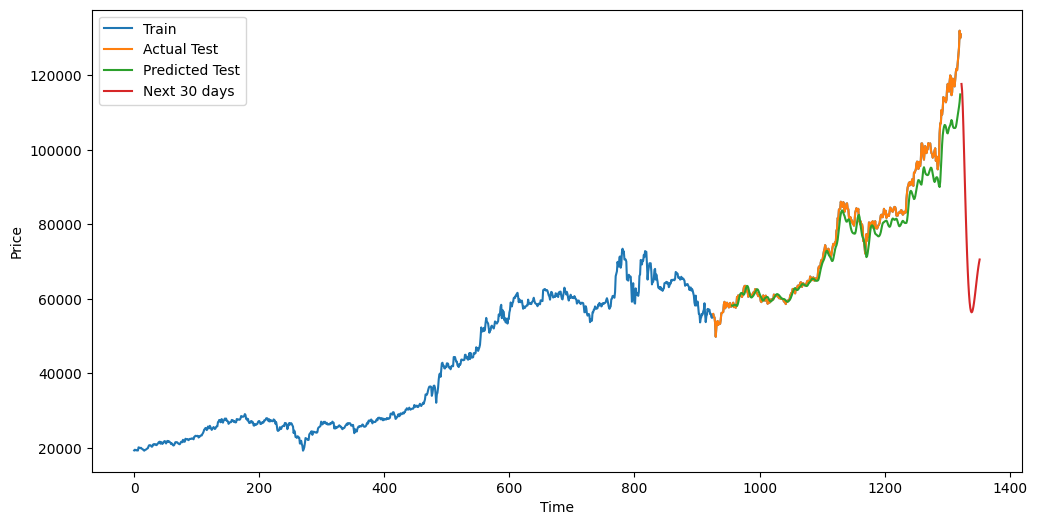

In [52]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 8/2)

In [53]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [54]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [55]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [56]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [57]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [58]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [59]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 140ms/step - loss: 0.0179 - val_loss: 0.0482
Epoch 2/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/100
17/17 [==============================] - 1s 60ms/step - loss: 8.9643e-04 - val_loss: 0.0028
Epoch 4/100
17/17 [==============================] - 1s 61ms/step - loss: 4.6583e-04 - val_loss: 0.0039
Epoch 5/100
17/17 [==============================] - 1s 61ms/step - loss: 4.1528e-04 - val_loss: 0.0061
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 4.1634e-04 - val_loss: 0.0035
Epoch 7/100
17/17 [==============================] - 1s 78ms/step - loss: 4.6044e-04 - val_loss: 0.0059
Epoch 8/100
17/17 [==============================] - 2s 100ms/step - loss: 3.8077e-04 - val_loss: 0.0057
Epoch 9/100
17/17 [==============================] - 2s 97ms/step - loss: 3.6687e-04 - val_loss: 0.0047
Epoch 10/100
17/17 [==============================] - 1s 61ms/step - l

In [61]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 14ms/step


In [62]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 5907.2796369114085
MAPE trên tập test là: 4.716332671856804 %
MSLE trên tập test là: 0.0035083832417397423


In [64]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

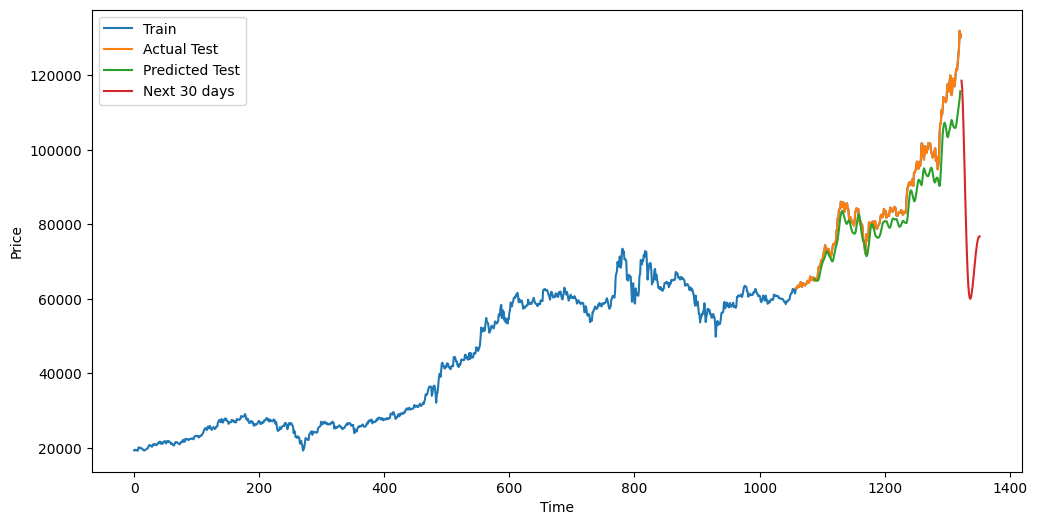

In [65]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 9/1)

In [66]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [67]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [68]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [69]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [70]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [71]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [72]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [73]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 8s 126ms/step - loss: 0.0146 - val_loss: 0.0163
Epoch 2/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/100
19/19 [==============================] - 1s 58ms/step - loss: 6.8718e-04 - val_loss: 0.0086
Epoch 4/100
19/19 [==============================] - 2s 92ms/step - loss: 4.9512e-04 - val_loss: 0.0055
Epoch 5/100
19/19 [==============================] - 2s 95ms/step - loss: 4.7661e-04 - val_loss: 0.0053
Epoch 6/100
19/19 [==============================] - 1s 71ms/step - loss: 4.8331e-04 - val_loss: 0.0069
Epoch 7/100
19/19 [==============================] - 1s 58ms/step - loss: 4.8500e-04 - val_loss: 0.0062
Epoch 8/100
19/19 [==============================] - 1s 57ms/step - loss: 4.6526e-04 - val_loss: 0.0065
Epoch 9/100
19/19 [==============================] - 1s 59ms/step - loss: 4.5428e-04 - val_loss: 0.0045
Epoch 10/100
19/19 [==============================] - 1s 58ms/step - lo

In [74]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

4/4 [==============================] - 1s 12ms/step


In [75]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [76]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2271.8328807647563
MAPE trên tập test là: 1.621142339144766 %
MSLE trên tập test là: 0.0004934542870326668


In [77]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

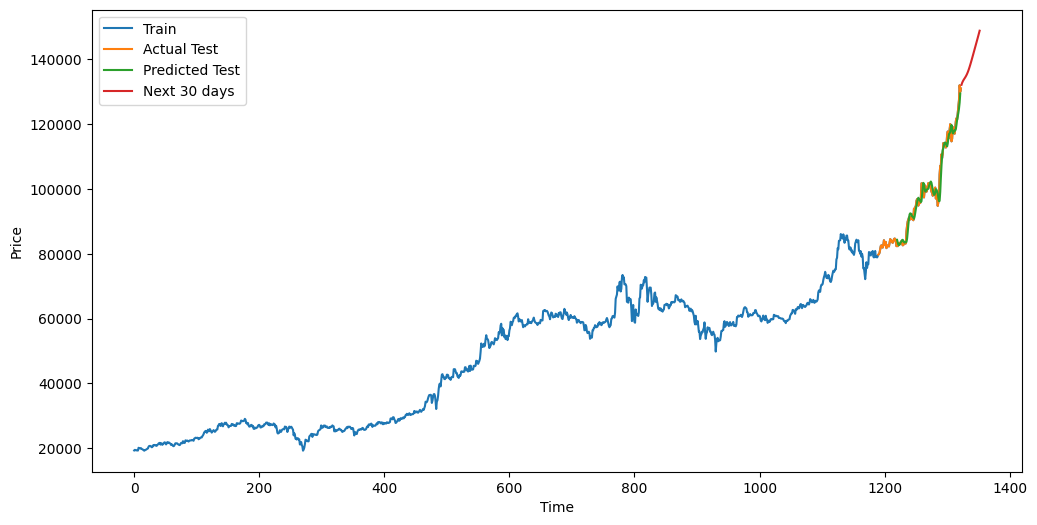

In [78]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()